## Mod 5 Project
#### Machine Learning Classification
This project is an analysis of a number of Starcraft 2 players. The goal of the project is to classify players into an appropriate league based on their playing statistics and habits.

Database Source: https://www.kaggle.com/danofer/skillcraft/data#SkillCraft.csv

### Imports & Data Inspection/Cleaning

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

from sklearn import svm, tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
data = pd.read_csv("SkillCraft.csv")
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [3]:
data.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [4]:
data['GameID'].value_counts()

4094    1
513     1
685     1
4779    1
6826    1
       ..
5300    1
5296    1
7341    1
3243    1
4098    1
Name: GameID, Length: 3338, dtype: int64

In [5]:
#Dropping GameID column as it is just a unique identifier.
data.drop(columns = 'GameID', inplace = True)

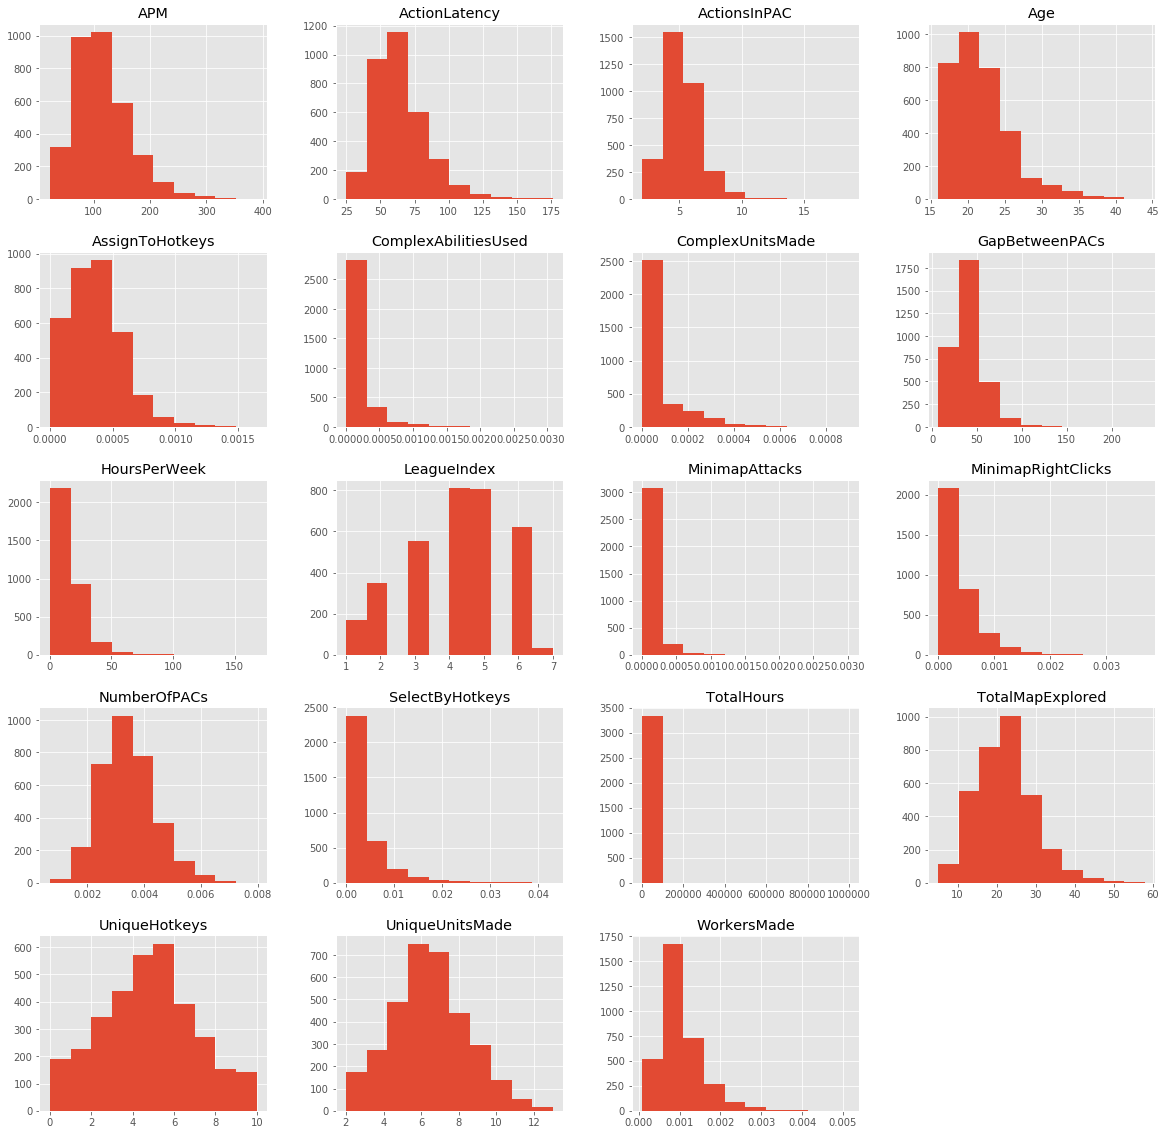

In [6]:
data.hist(figsize = (20, 20))
plt.show()

### Train/Test Split & Normalization

In [7]:
y = data['LeagueIndex']
X = data.drop(columns = 'LeagueIndex')

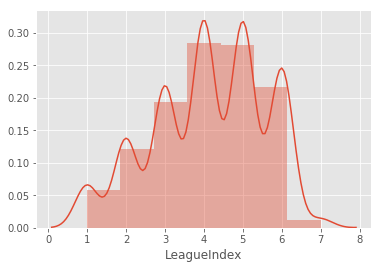

In [8]:
sns.distplot(y, bins = 7)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

In [10]:
sm = SMOTE()
X_train_sample, y_train_sample = sm.fit_resample(X_train, y_train)
X_train_sample = pd.DataFrame(X_train_sample, 
                              columns = X.columns)

In [11]:
scaler = StandardScaler()
X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                              columns = X.columns, index = X_test.index)

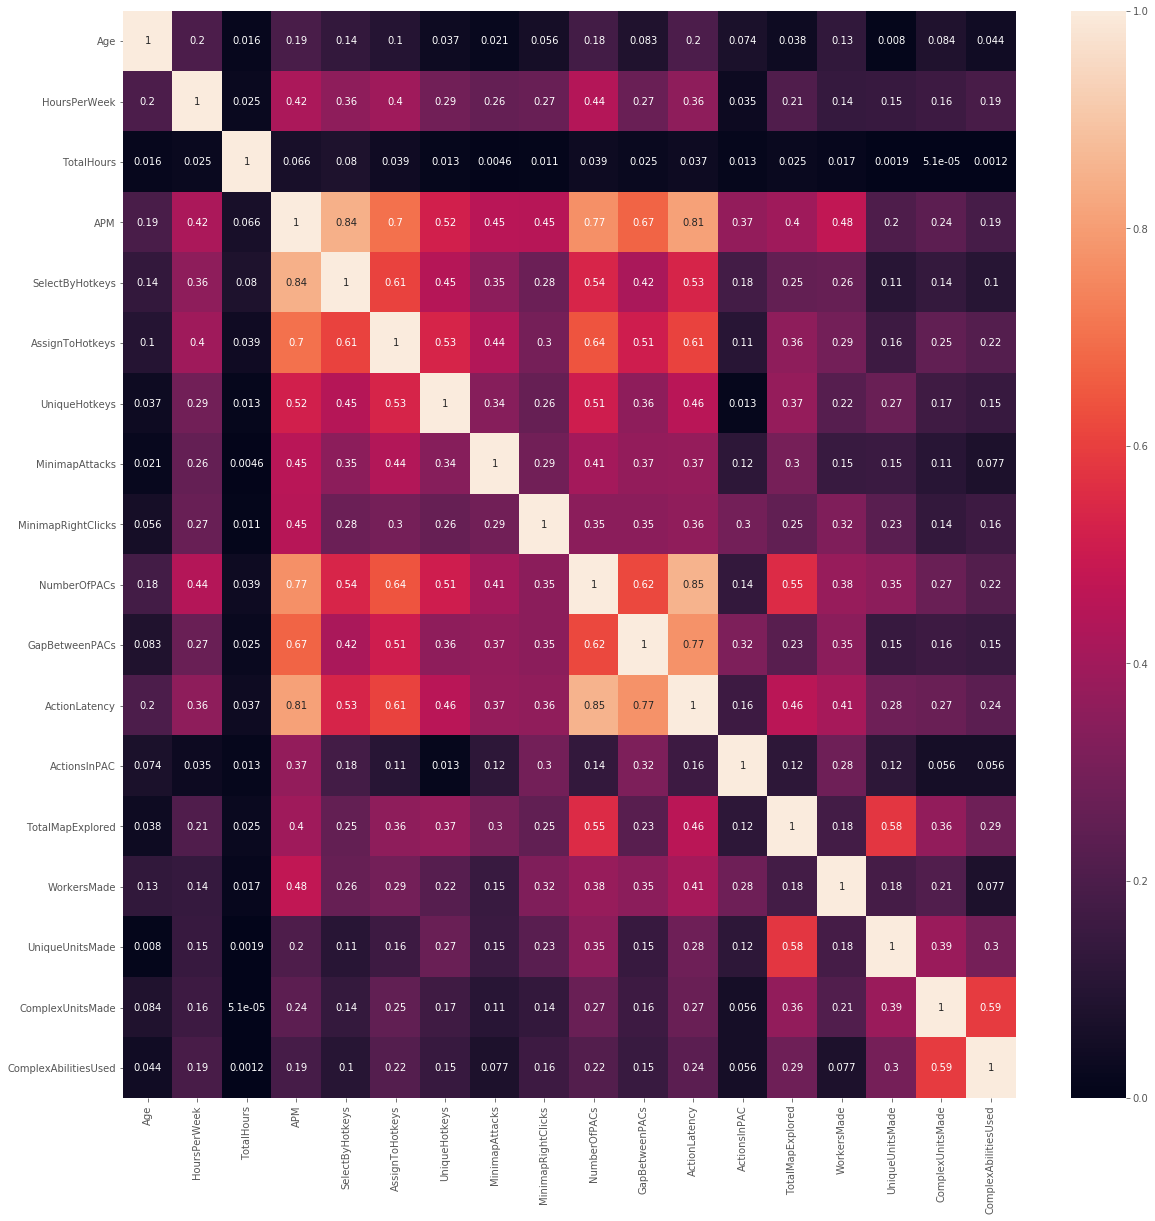

In [12]:
plt.figure(figsize = [20, 20])
sns.heatmap(X_train_scaled_sample.corr().abs(), annot = True)

# Modeling
### Function Creation

In [13]:
def fit_model(clf, X_train, X_test, y_train, y_test,
              param_grid, scoring = 'accuracy', cv = 3,
              feature_importances = None, title = None):
    """
    This function will fit a model using the provided classifier, dataset, 
    and parameter grid. It uses GridSearchCV to determine the best model.
    
    INPUTS:
    clf                 = Classifier to be fit
    X_train,X_test,y_train,y_test = train/test data to be used 
    param_grid          = Parameter grid to be used for the gridsearch
    scoring             = Scoring method to be used for the gridsearch
    cv                  = Number of cross-validations
    feature_importances = Number of top features to print
    title               = Title to print for clarity when reviewing outputs
    
    OUTPUTS:
    Returns the best estimator model from GridSearch. 
    Prints title, score, feature importances to screen.
    """
    grid_clf = GridSearchCV(estimator = clf, param_grid = param_grid, 
                            cv = cv, scoring = scoring)
    grid_clf.fit(X_train, y_train)
    if title:
        print(title)
    print(" BEST PARAMS:")
    print(grid_clf.best_params_)
    print("\nBest", scoring.capitalize() ,"Score:",round(grid_clf.best_score_,4))

    #Get Stats for Train Test Split just to verify that crossvalidation was good.
    print_model_stats(grid_clf, X_train, X_test, y_train, y_test)
    if feature_importances:
        try:
            print("")
            get_feature_importances(grid_clf.best_estimator_, X_train, num_features=feature_importances)
        except:
            pass
    return grid_clf.best_estimator_

In [14]:
def get_feature_importances(estimator, df, num_features=10):
    """
    This function will print the feature importances from the provided model
    and dataframe.
    
    INPUTS:
    estimator    = The model that has been fit.
    df           = The dataframe containing model features.
    num_features = The number of features to print.
    """
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    if len(importances) < num_features:
        num_features = len(importances)
    print("Feature ranking:")
    for idx, f_idx in enumerate(indices[0:num_features]):
        print(f"{idx+1}: Score {round(importances[f_idx],3)}, Feature Name: {df.columns[f_idx]}")
    return

In [15]:
def print_model_stats(estimator, X_train, X_test, y_train, y_test):
    """
    This function prints the accuracy and precision score for the provided
    model using the training and test datasets provided.
    """
    y_pred_train = estimator.predict(X_train)
    y_pred_test  = estimator.predict(X_test)
    print(" TRAINING:  Accuracy:",round(accuracy_score(y_train,y_pred_train),4))
    print(" TEST:      Accuracy:",round(accuracy_score(y_test,y_pred_test),4))   
    return

### Creating Classifiers & Parameter Grids

In [16]:
rf_clf = RandomForestClassifier()
param_grid_rf = [{'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 2, 4, 6, 8, 10],
                  'n_estimators': [50, 100],
                  'max_features': ['auto', 5, 8, 10]}]

In [17]:
xgb_clf = XGBClassifier()
param_grid_xgb = [{'max_depth': [2, 3, 4, 5],
                   'n_estimators': [50, 100],
                   'learning_rate': [0.1, 0.2],
                   'gamma': [0, 1] }]

In [18]:
svc_clf = SVC()
param_grid_svc = [{'C': [1.0],
                   'gamma': ['auto'] }]

In [19]:
ovrx_clf = OneVsRestClassifier(XGBClassifier())
param_grid_ovrx = [{'estimator__max_depth': [2, 3, 4, 5],
                   'estimator__n_estimators': [50, 100],
                   'estimator__learning_rate': [0.1, 0.2],
                   'estimator__gamma': [0, 1] }]

In [20]:
ovrs_clf = OneVsRestClassifier(SVC())
param_grid_ovrs = [{'estimator__C': [1.0],
                   'estimator__gamma': ['auto'] }]

### Testing Models

In [21]:
fit_model(rf_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'n_estimators': 100}

Best Accuracy Score: 0.6657
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.4052

Feature ranking:
1: Score 0.202, Feature Name: ActionLatency
2: Score 0.13, Feature Name: APM
3: Score 0.076, Feature Name: TotalHours
4: Score 0.073, Feature Name: MinimapAttacks
5: Score 0.059, Feature Name: SelectByHotkeys
6: Score 0.053, Feature Name: NumberOfPACs
7: Score 0.05, Feature Name: AssignToHotkeys
8: Score 0.046, Feature Name: GapBetweenPACs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
fit_model(xgb_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6059
 TRAINING:  Accuracy: 0.9963
 TEST:      Accuracy: 0.3942


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
fit_model(svc_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5312
 TRAINING:  Accuracy: 0.6322
 TEST:      Accuracy: 0.3623


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
fit_model(ovrx_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6143
 TRAINING:  Accuracy: 0.9988
 TEST:      Accuracy: 0.3952


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [25]:
fit_model(ovrs_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.527
 TRAINING:  Accuracy: 0.7259
 TEST:      Accuracy: 0.3214


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### Removing Multi-Colinearity

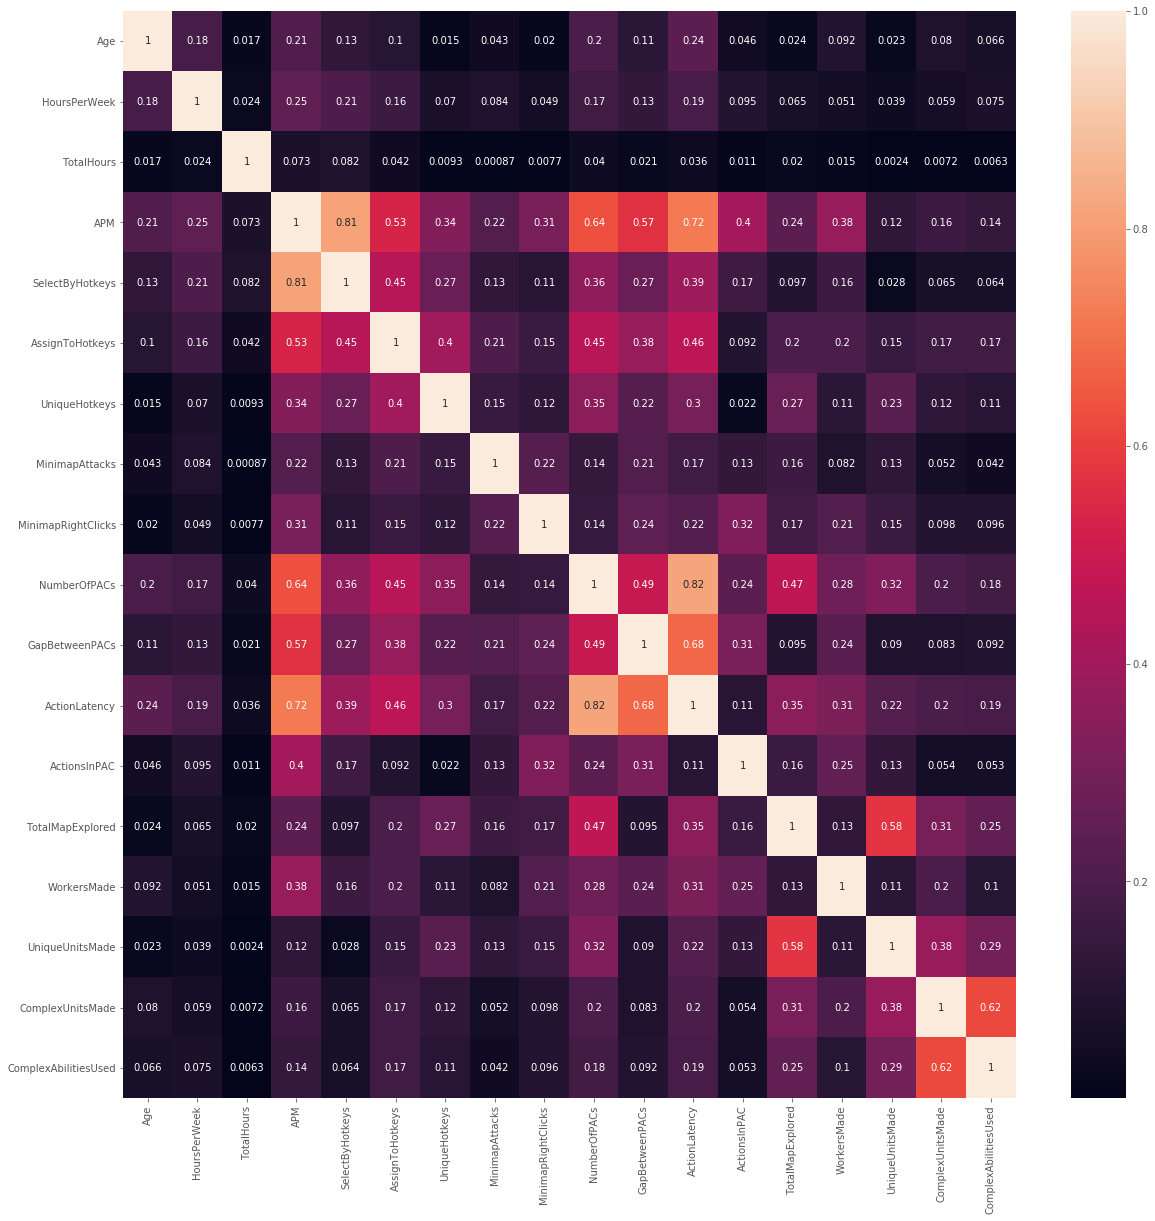

In [26]:
plt.figure(figsize = [20, 20])
sns.heatmap(X.corr().abs(), annot = True)

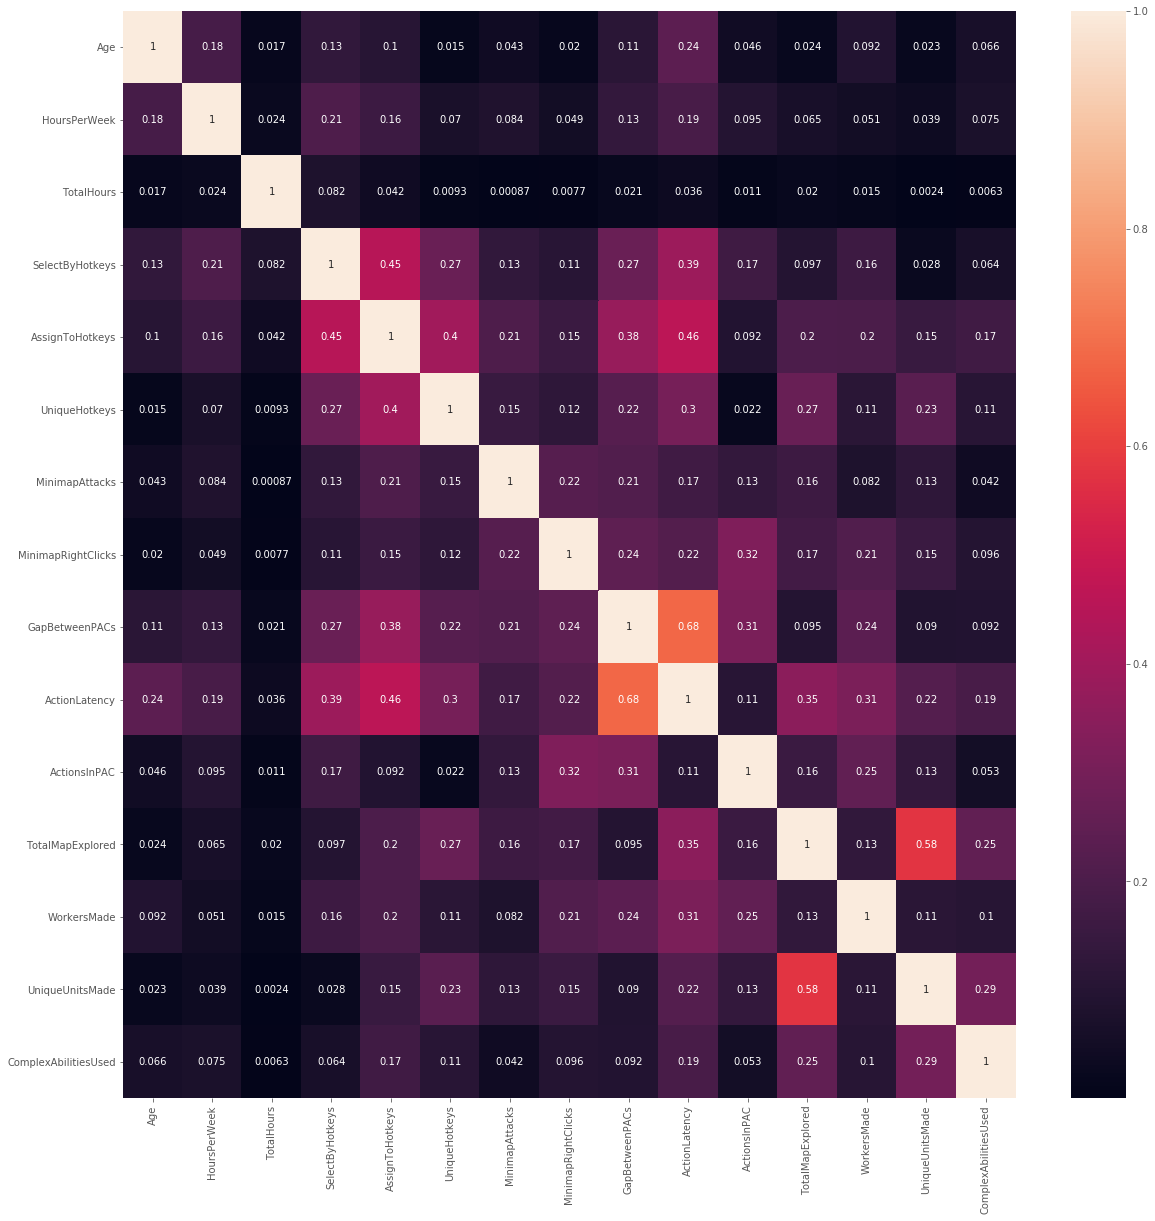

In [27]:
columns_to_remove = ['APM', 'NumberOfPACs', 'ComplexUnitsMade']
X_filtered = X.drop(columns = columns_to_remove)
plt.figure(figsize = [20, 20])
sns.heatmap(X_filtered.corr().abs(), annot = True)

In [28]:
X_filt_train, X_filt_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size = 0.30, random_state = 42)

In [29]:
sm = SMOTE()
X_filt_train_sample, y_train_sample = sm.fit_resample(X_filt_train, y_train)
X_filt_train_sample = pd.DataFrame(X_filt_train_sample, 
                              columns = X_filtered.columns)

In [30]:
scaler = StandardScaler()
X_filt_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_filt_train_sample), 
                              columns = X_filtered.columns, index = X_filt_train_sample.index)
X_filt_test_scaled = pd.DataFrame(scaler.transform(X_filt_test), 
                              columns = X_filtered.columns, index = X_filt_test.index)

In [31]:
fit_model(rf_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 50}

Best Accuracy Score: 0.654
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.3962

Feature ranking:
1: Score 0.201, Feature Name: ActionLatency
2: Score 0.118, Feature Name: SelectByHotkeys
3: Score 0.083, Feature Name: GapBetweenPACs
4: Score 0.08, Feature Name: TotalHours
5: Score 0.08, Feature Name: MinimapAttacks
6: Score 0.072, Feature Name: AssignToHotkeys
7: Score 0.053, Feature Name: UniqueHotkeys
8: Score 0.05, Feature Name: WorkersMade


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
fit_model(xgb_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6049
 TRAINING:  Accuracy: 0.9933
 TEST:      Accuracy: 0.3972


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
fit_model(svc_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5255
 TRAINING:  Accuracy: 0.6354
 TEST:      Accuracy: 0.3533


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
fit_model(ovrx_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6146
 TRAINING:  Accuracy: 0.9973
 TEST:      Accuracy: 0.4062


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [35]:
fit_model(ovrs_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5241
 TRAINING:  Accuracy: 0.7145
 TEST:      Accuracy: 0.3194


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### PCA

In [36]:
pca = PCA()
X_train_sample_trans = pd.DataFrame(pca.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_trans = pd.DataFrame(pca.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

In [37]:
fit_model(rf_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6687
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.1766

Feature ranking:
1: Score 0.235, Feature Name: HoursPerWeek
2: Score 0.124, Feature Name: Age
3: Score 0.062, Feature Name: TotalHours
4: Score 0.048, Feature Name: APM
5: Score 0.046, Feature Name: UniqueUnitsMade
6: Score 0.045, Feature Name: MinimapAttacks
7: Score 0.041, Feature Name: NumberOfPACs
8: Score 0.038, Feature Name: SelectByHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
fit_model(xgb_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6285
 TRAINING:  Accuracy: 0.9955
 TEST:      Accuracy: 0.1936


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
fit_model(svc_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.4286
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.2345


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
fit_model(ovrx_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6307
 TRAINING:  Accuracy: 0.9985
 TEST:      Accuracy: 0.1766


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [41]:
fit_model(ovrs_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5082
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.2335


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

# Refinement
As none of our models have had better than about 36% accuracy thus far, the next step will be to try reducing the number of classes down to three (Beginner, Advanced, and Expert). The original classes will be binned as 1-3 (Bronze, Silver, Gold) into Beginner, 4 and 5 (Platinum and Diamond) into Advanced, and 6 and 7 (Master and Grandmaster) into Expert.

In [42]:
y.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

In [43]:
y_group = y.map(lambda x: 'Beginner' if x in [1, 2, 3] else 
                'Advanced' if x in [4, 5] else 'Expert')
y_group.head()

0    Advanced
1    Advanced
2    Advanced
3    Beginner
4    Beginner
Name: LeagueIndex, dtype: object

In [44]:
y_group.value_counts()

Advanced    1615
Beginner    1067
Expert       656
Name: LeagueIndex, dtype: int64

In [45]:
X_train, X_test, y_group_train, y_group_test = train_test_split(
    X, y_group, test_size = 0.30, random_state = 42)

In [46]:
sm = SMOTE()
X_train_sample, y_group_train_sample = sm.fit_resample(X_train, y_group_train)
X_train_sample = pd.DataFrame(X_train_sample, 
                              columns = X.columns)

In [47]:
scaler = StandardScaler()
X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                              columns = X.columns, index = X_test.index)

### Initial Models

In [48]:
fit_model(rf_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}

Best Accuracy Score: 0.7639
 TRAINING:  Accuracy: 0.9997
 TEST:      Accuracy: 0.6537

Feature ranking:
1: Score 0.153, Feature Name: ActionLatency
2: Score 0.121, Feature Name: APM
3: Score 0.078, Feature Name: NumberOfPACs
4: Score 0.077, Feature Name: SelectByHotkeys
5: Score 0.076, Feature Name: TotalHours
6: Score 0.062, Feature Name: GapBetweenPACs
7: Score 0.058, Feature Name: MinimapAttacks
8: Score 0.057, Feature Name: AssignToHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
fit_model(xgb_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

Best Accuracy Score: 0.7347
 TRAINING:  Accuracy: 0.8856
 TEST:      Accuracy: 0.6627


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
fit_model(svc_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.6953
 TRAINING:  Accuracy: 0.7668
 TEST:      Accuracy: 0.6357


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
fit_model(ovrx_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 50}

Best Accuracy Score: 0.7341
 TRAINING:  Accuracy: 0.8905
 TEST:      Accuracy: 0.6637


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [52]:
fit_model(ovrs_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.69
 TRAINING:  Accuracy: 0.7668
 TEST:      Accuracy: 0.6188


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### Removing Multi-Collinearity
Based on the Feature Ranking from our Random Forest, we'll remove the features with the most collinearity and the least effect.

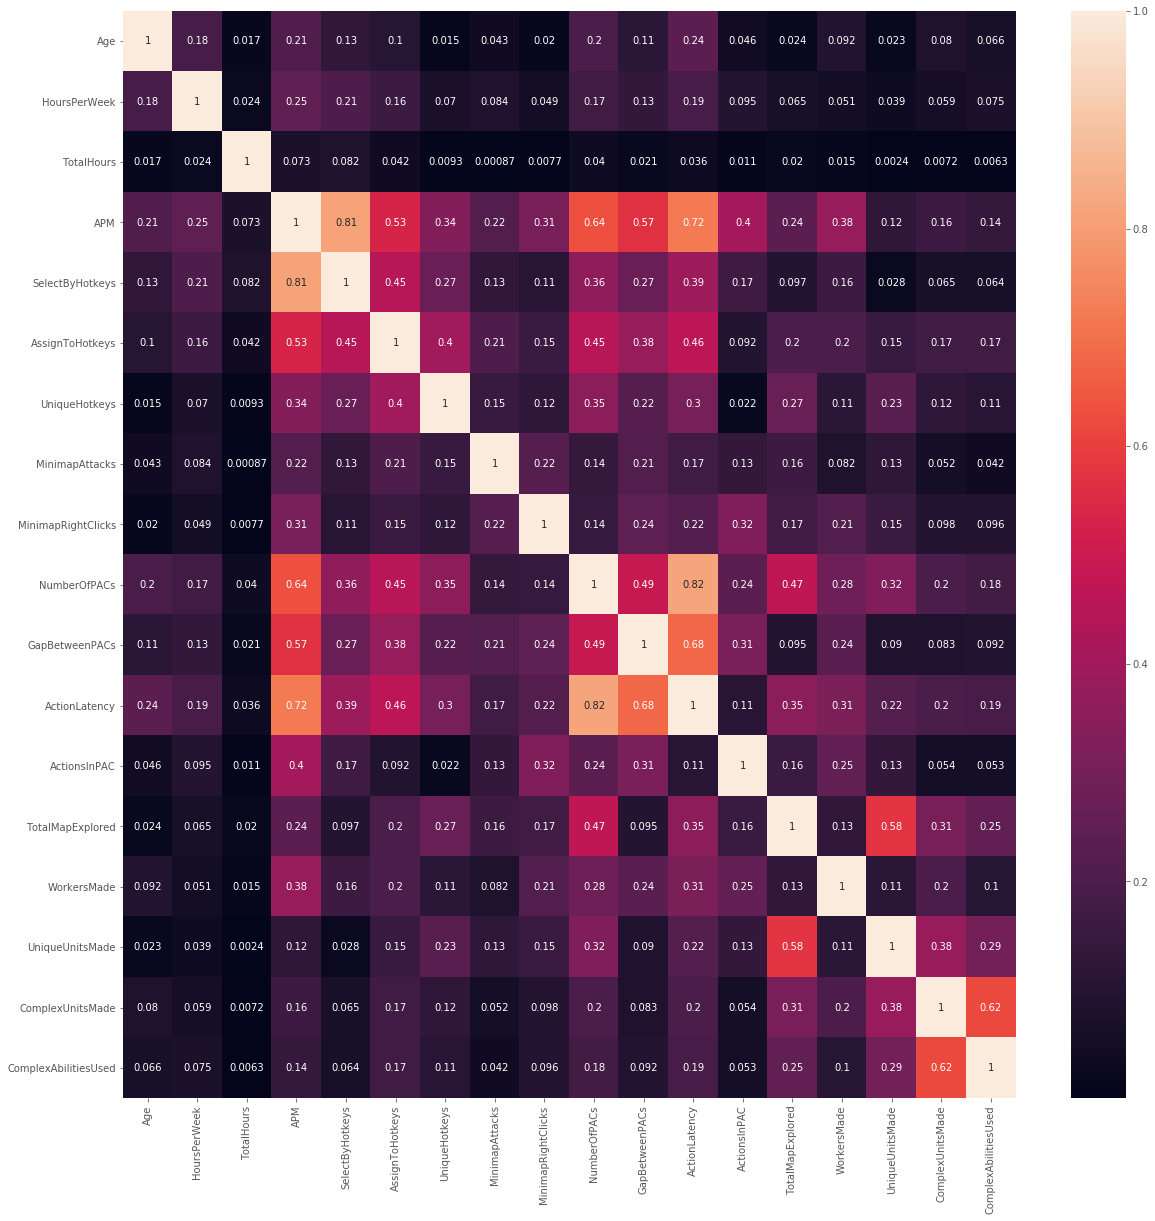

In [53]:
plt.figure(figsize = [20, 20])
sns.heatmap(X.corr().abs(), annot = True)

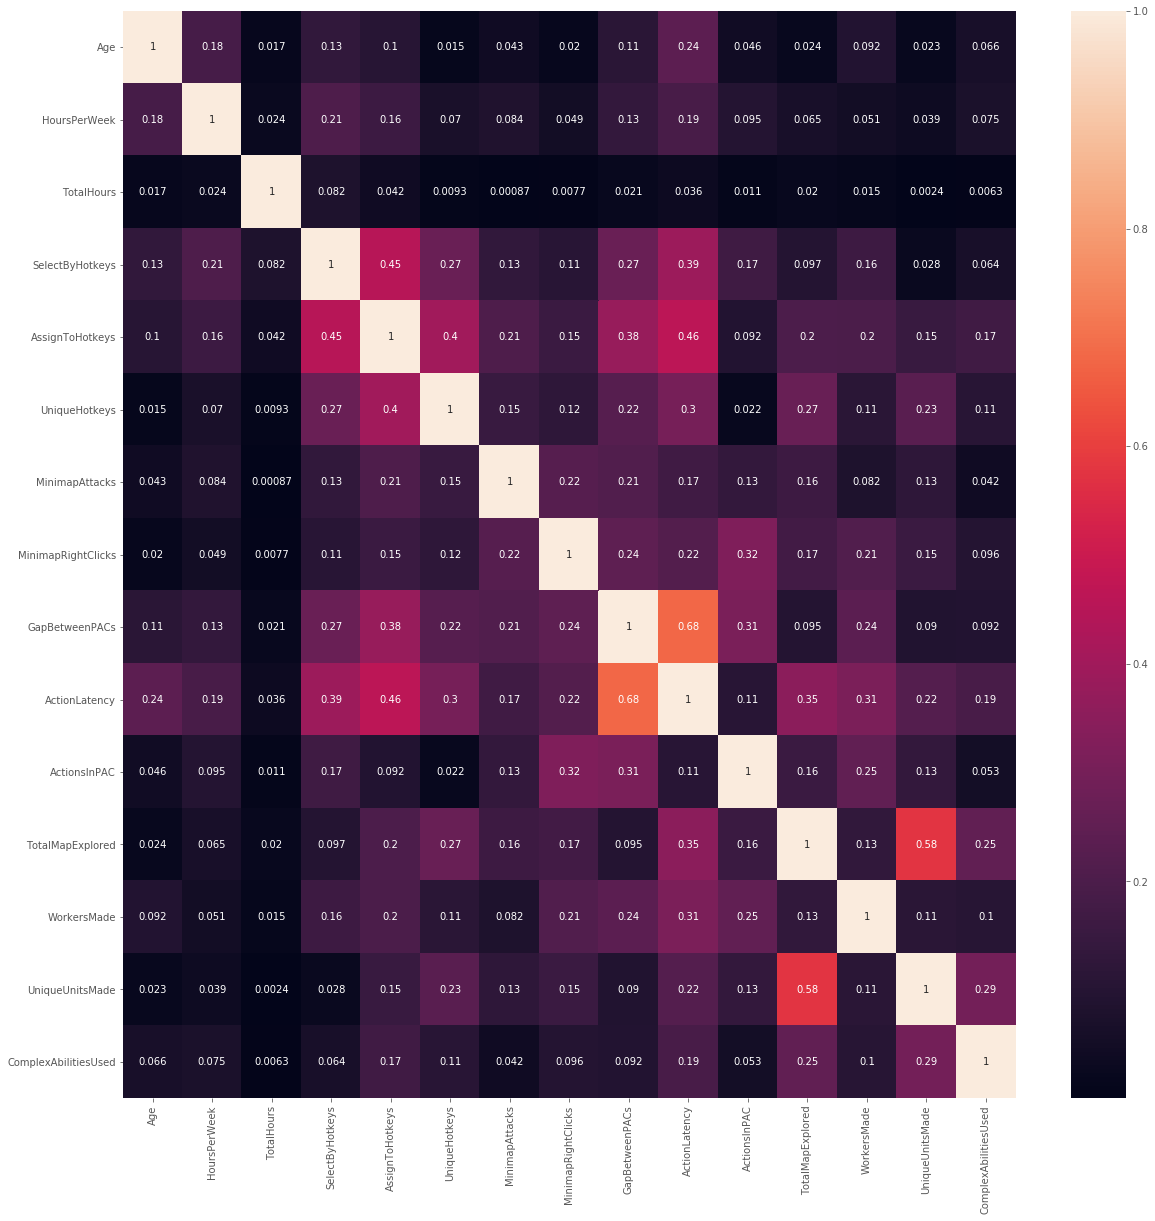

In [54]:
columns_to_remove = ['APM', 'NumberOfPACs', 'ComplexUnitsMade']
X_filtered = X.drop(columns = columns_to_remove)
plt.figure(figsize = [20, 20])
sns.heatmap(X_filtered.corr().abs(), annot = True)

In [55]:
X_filt_train, X_filt_test, y_group_train, y_group_test = train_test_split(
    X_filtered, y_group, test_size = 0.30, random_state = 42)

In [56]:
sm = SMOTE()
X_filt_train_sample, y_group_train_sample = sm.fit_resample(X_filt_train, y_group_train)
X_filt_train_sample = pd.DataFrame(X_filt_train_sample, 
                              columns = X_filtered.columns)

In [57]:
scaler = StandardScaler()
X_filt_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_filt_train_sample), 
                              columns = X_filtered.columns, index = X_filt_train_sample.index)
X_filt_test_scaled = pd.DataFrame(scaler.transform(X_filt_test), 
                              columns = X_filtered.columns, index = X_filt_test.index)

In [58]:
fit_model(rf_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

Best Accuracy Score: 0.7557
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6637

Feature ranking:
1: Score 0.152, Feature Name: ActionLatency
2: Score 0.116, Feature Name: SelectByHotkeys
3: Score 0.097, Feature Name: GapBetweenPACs
4: Score 0.094, Feature Name: TotalHours
5: Score 0.075, Feature Name: AssignToHotkeys
6: Score 0.063, Feature Name: MinimapAttacks
7: Score 0.057, Feature Name: UniqueHotkeys
8: Score 0.055, Feature Name: WorkersMade


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
fit_model(xgb_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.7259
 TRAINING:  Accuracy: 0.9869
 TEST:      Accuracy: 0.6527


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [60]:
fit_model(svc_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.6926
 TRAINING:  Accuracy: 0.763
 TEST:      Accuracy: 0.6158


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [61]:
fit_model(ovrx_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.7277
 TRAINING:  Accuracy: 0.9416
 TEST:      Accuracy: 0.6577


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [62]:
fit_model(ovrs_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.683
 TRAINING:  Accuracy: 0.7639
 TEST:      Accuracy: 0.5878


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

# Results & Conclusion

Thus far, our best model was the Random Forest after reducing our number of classes down to three and removing a number of multi-collinear features.

In [63]:
best_estimator = GridSearchCV(rf_clf, param_grid_rf, cv = 3, scoring = 'accuracy')
best_estimator.fit(X_filt_train_scaled_sample, y_group_train_sample)
y_pred = best_estimator.best_estimator_.predict(X_filt_test_scaled)

Text(0.5, 1.0, 'Random Forest Best Estimator Actual vs Predicted Values')

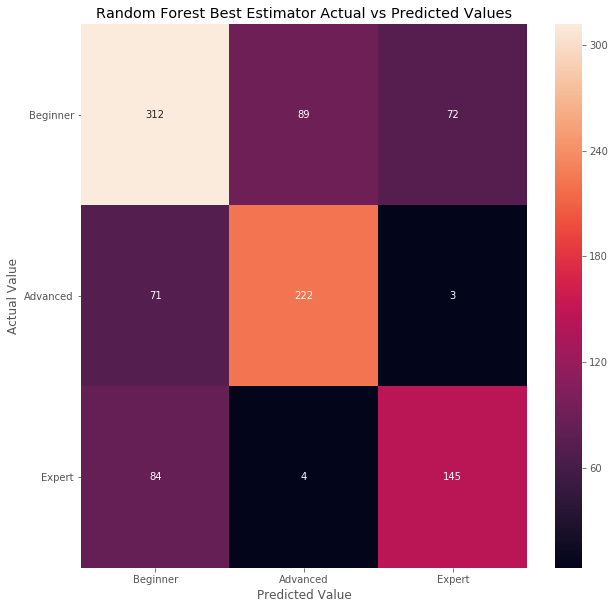

In [64]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(y_group_test, y_pred), annot = True, fmt = 'g', 
            xticklabels = ['Beginner', 'Advanced', 'Expert'], 
            yticklabels = ['Beginner', 'Advanced', 'Expert'])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.yticks(rotation = 0)
plt.title("Random Forest Best Estimator Actual vs Predicted Values")

As you can see from the Confusion Matrix, we're still only about 66% accurate, and tend to miss the Beginner rank the most. This is most likely due to the fact that most players are able to play at a higher tier but aren't able to devote the time to get through the lower ranks of Bronze, Silver, and Gold. 

# Future Work
I would like to continue pushing on this, and figure out a way to adjust for those Beginner tier misclassifications, however I feel like the best way to go about that would be to more heavily weight the TotalHours feature, assuming that it is indeed the reason for those misses. If it's not, I have no idea where to go from there.

I would also like to eventually take each tier and create a model to further classify them back down into each league, if possible. The hardest tier to do would likely be Expert as the Grandmaster tier is very small by comparison.

# Additional EDA and Feature Engineering
To start off this section, I'll be creating Box Plots for each feature, comparing each group, and removing a handful of ridiculous outliers without losing too much data.

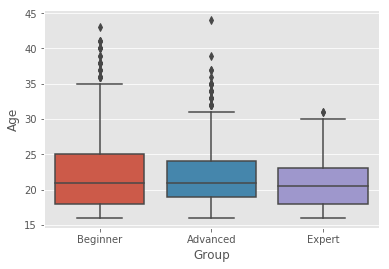

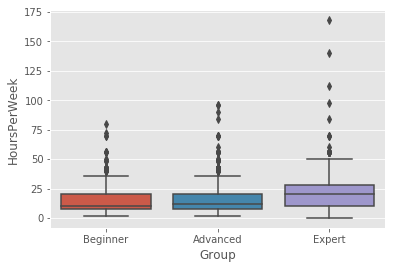

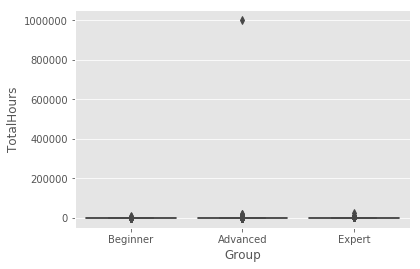

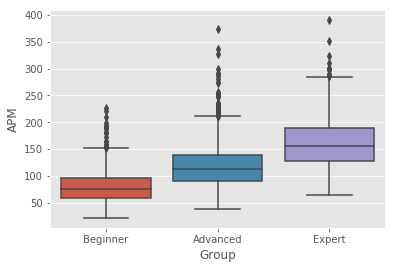

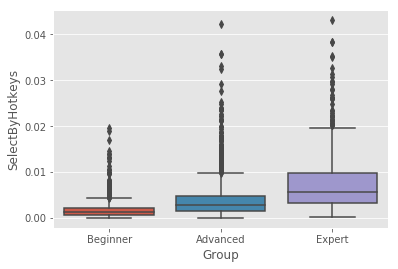

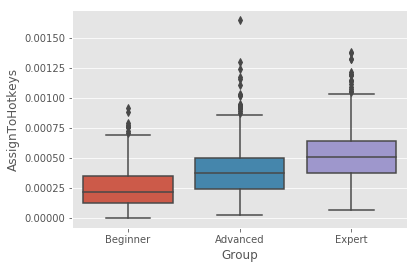

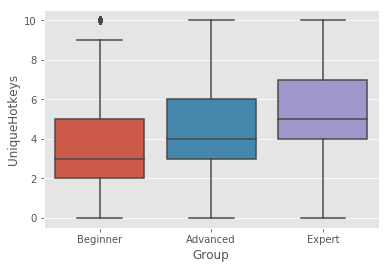

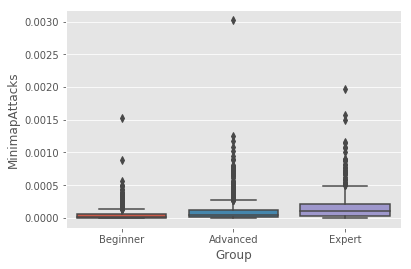

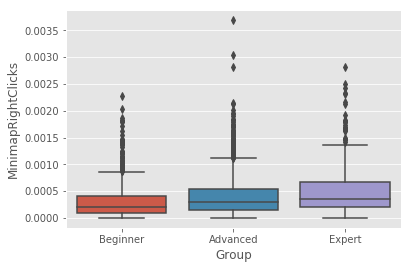

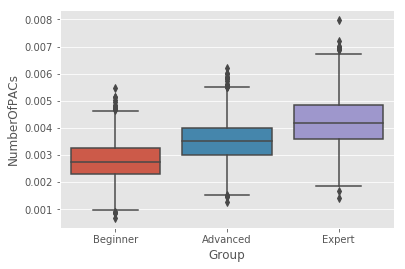

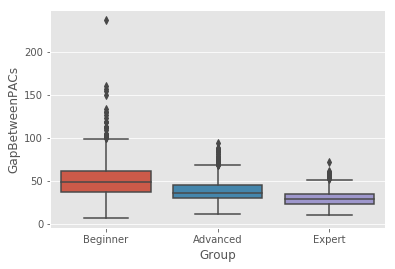

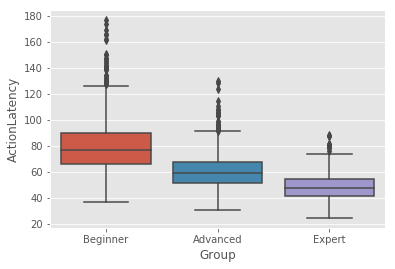

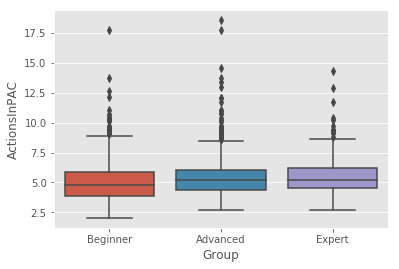

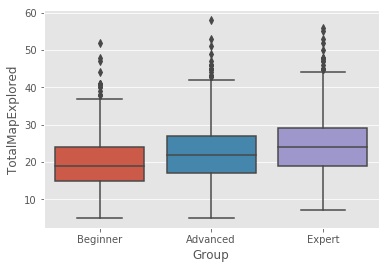

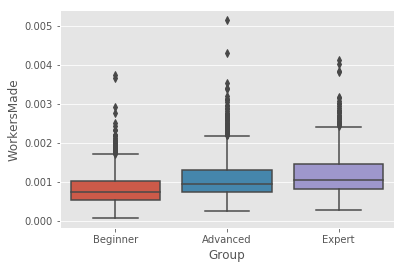

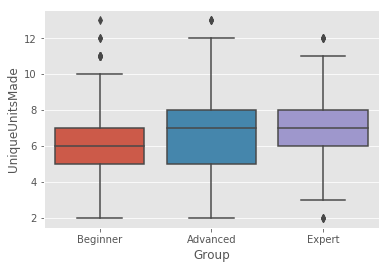

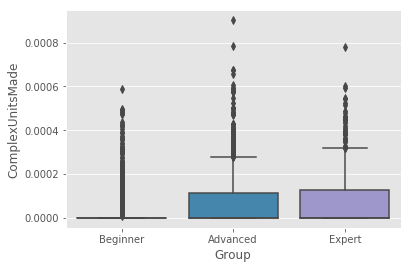

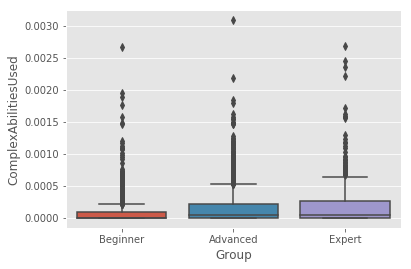

In [65]:
new_data = X.copy()
new_data['Group'] = y_group.values
new_data.head()
for col in X.columns:
    sns.boxplot(y = new_data[col], x = new_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [67]:
todrop = data[(data['HoursPerWeek'] > 100) | 
              (data['TotalHours'] > 3000) | 
              (data['MinimapAttacks'] > 0.00150)].index
new_data = data.drop(todrop)

In [68]:
new_y = new_data['LeagueIndex']
new_X = new_data.drop(columns = 'LeagueIndex')

In [69]:
new_y_group = new_y.map(lambda x: 'Beginner' if x in [1, 2, 3] else 
                'Advanced' if x in [4, 5] else 'Expert')
new_y_group.head()

0    Advanced
2    Advanced
3    Beginner
4    Beginner
5    Beginner
Name: LeagueIndex, dtype: object

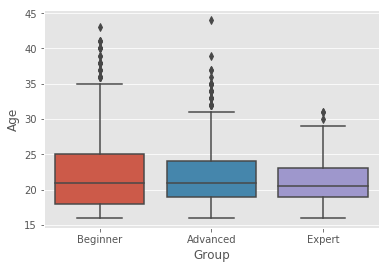

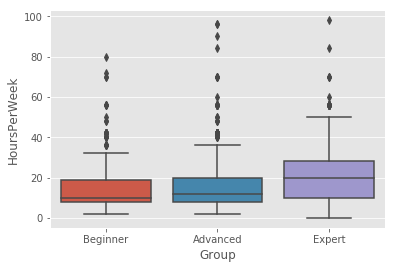

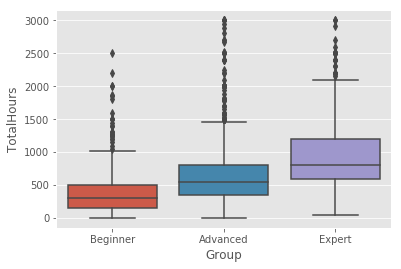

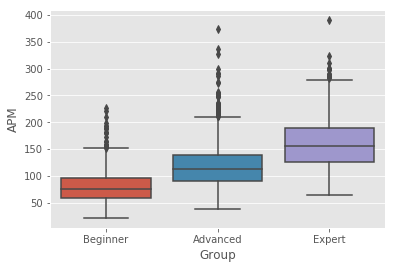

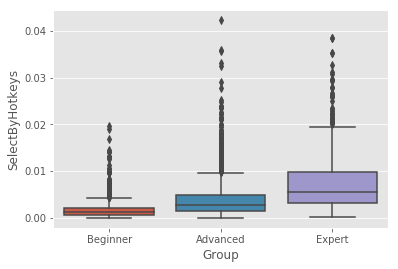

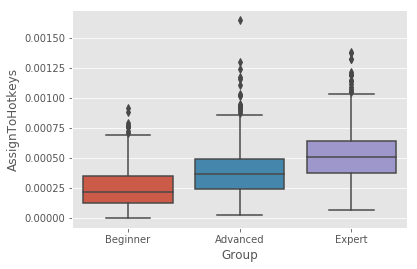

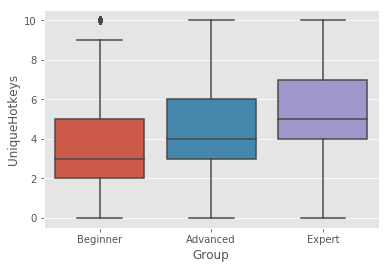

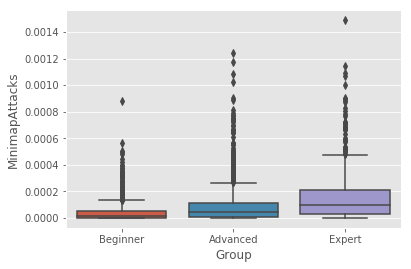

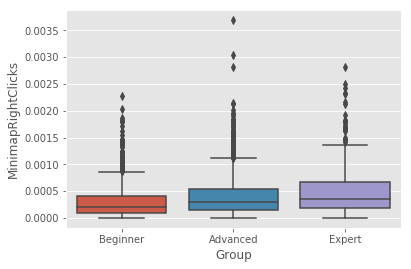

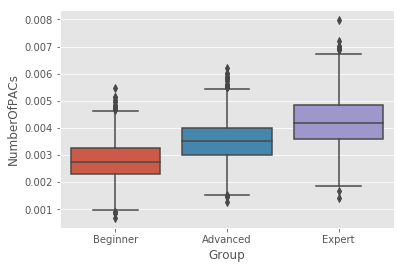

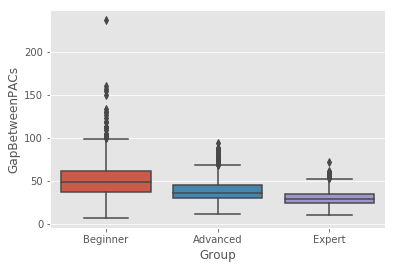

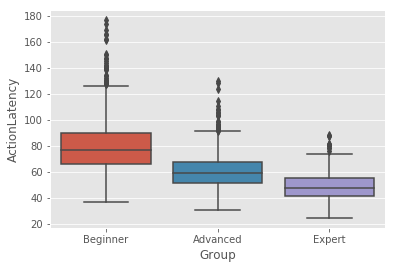

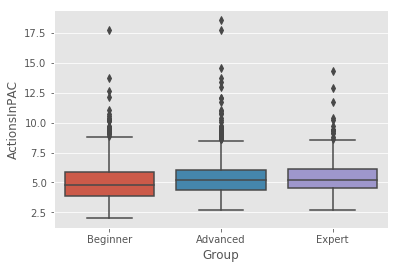

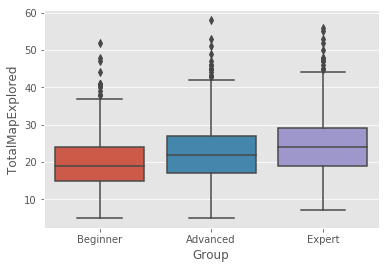

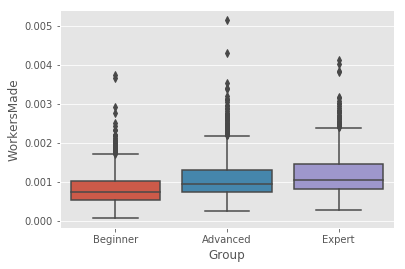

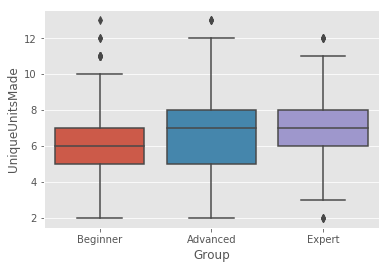

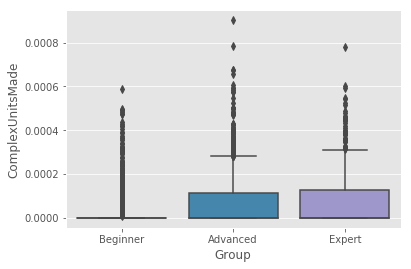

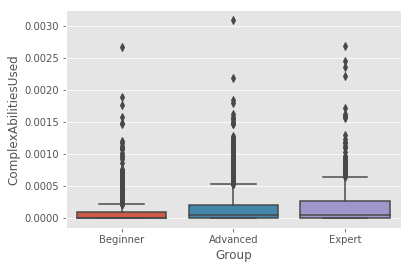

In [70]:
new_new_data = new_X.copy()
new_new_data['Group'] = new_y_group.values
for col in new_X.columns:
    sns.boxplot(y = new_new_data[col], x = new_new_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [71]:
new_new_data['ApproxYrsPlayed'] = (new_new_data['TotalHours'] / new_new_data['HoursPerWeek']) / 52

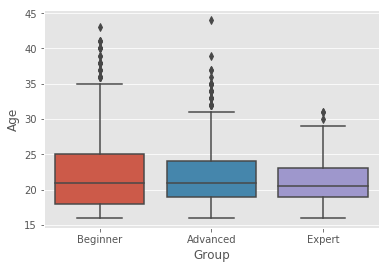

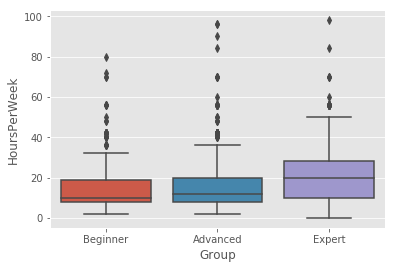

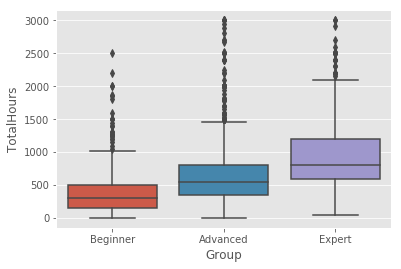

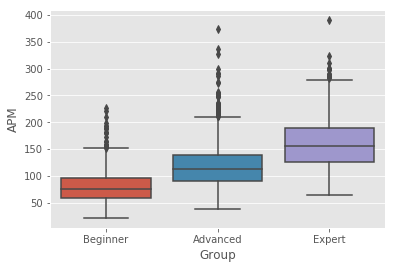

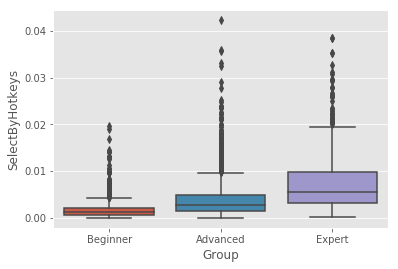

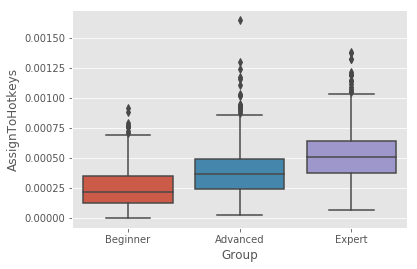

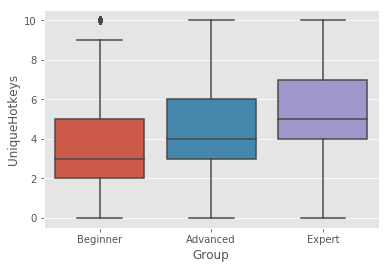

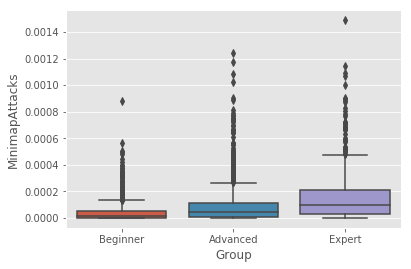

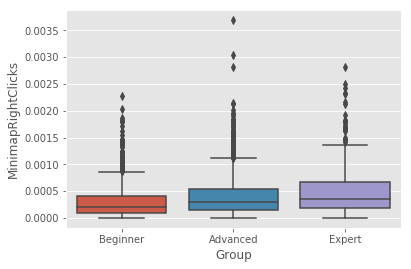

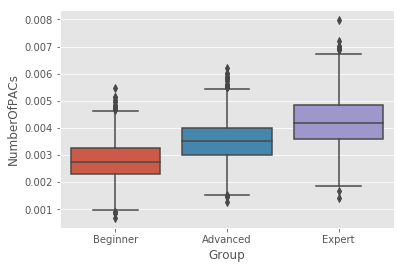

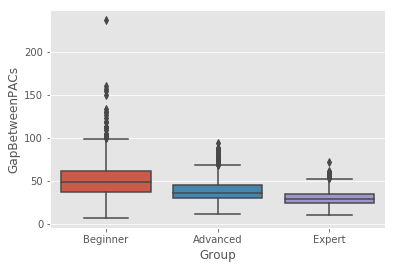

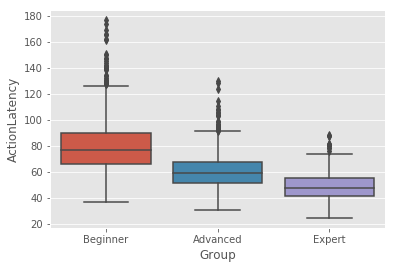

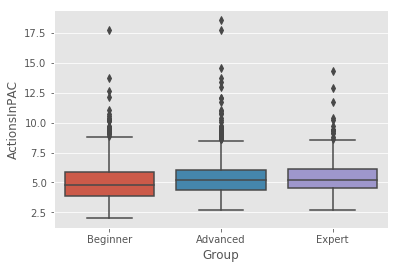

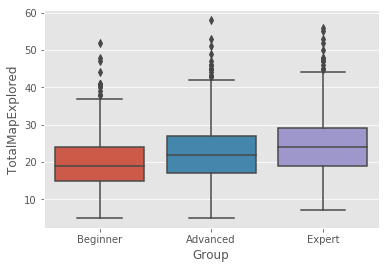

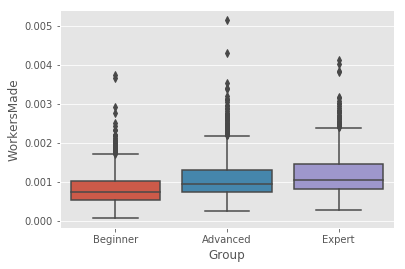

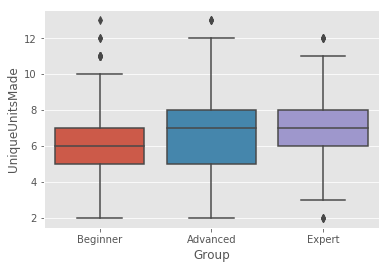

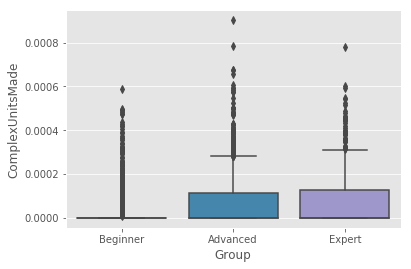

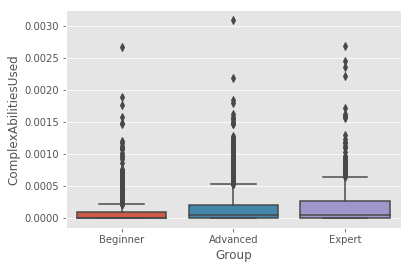

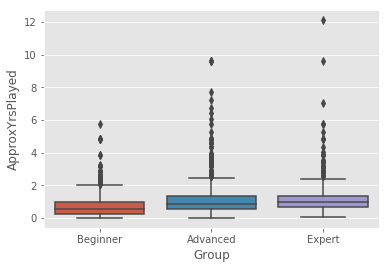

In [72]:
for col in new_new_data.drop('Group', axis = 1).columns:
    sns.boxplot(y = new_new_data[col], x = new_new_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [73]:
todrop = new_new_data[new_new_data['ApproxYrsPlayed'] > 6].index
fixed_data = new_new_data.drop(todrop)

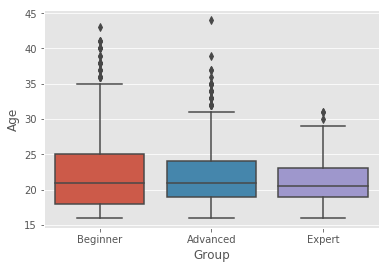

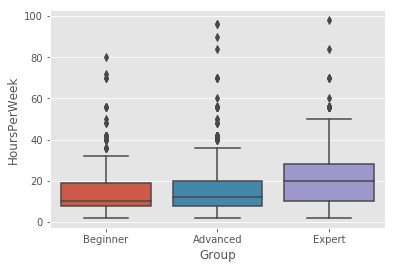

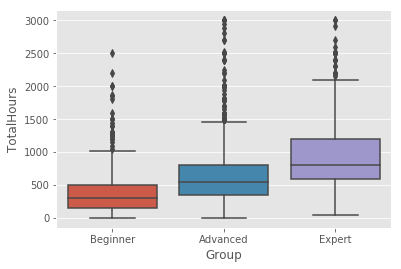

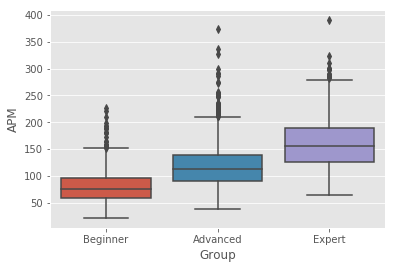

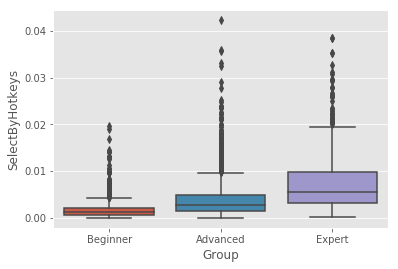

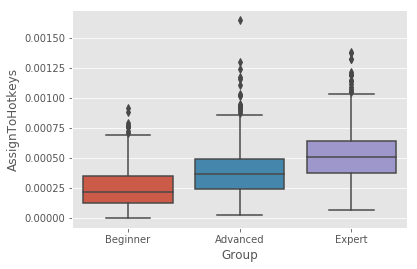

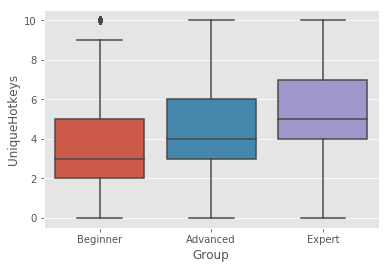

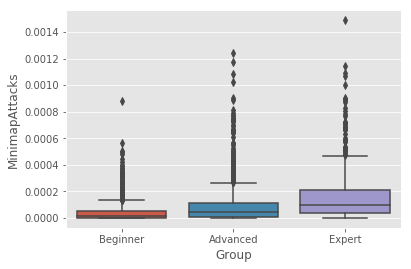

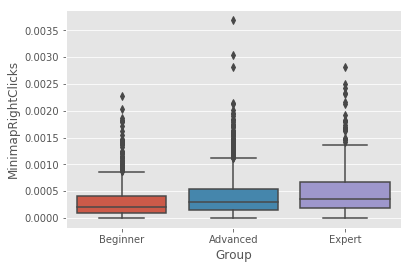

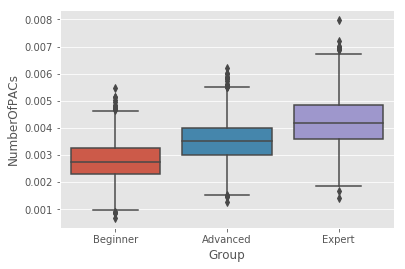

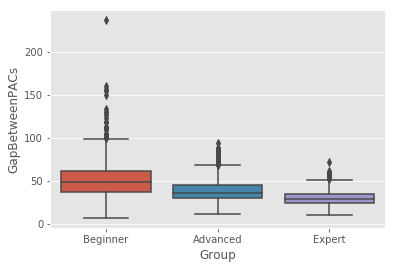

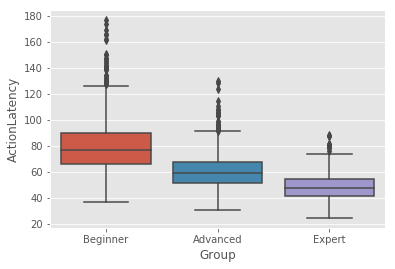

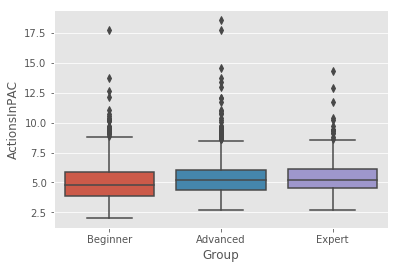

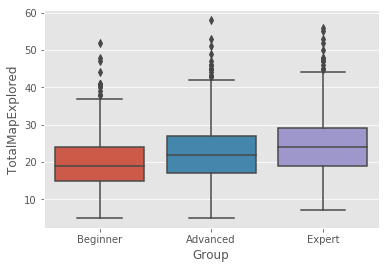

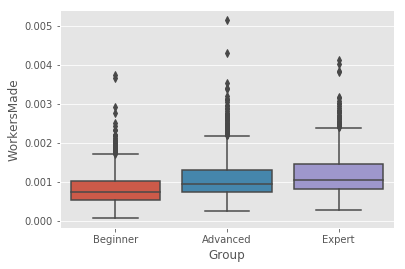

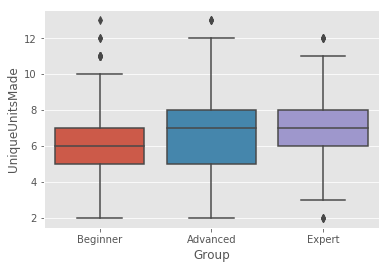

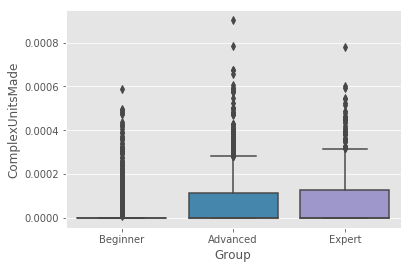

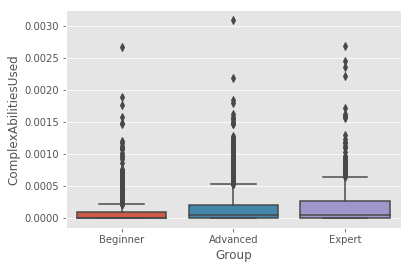

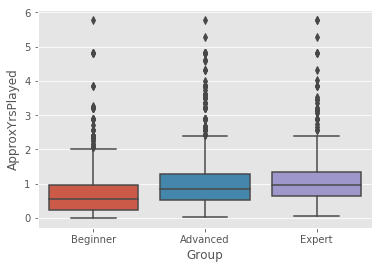

In [74]:
for col in fixed_data.drop('Group', axis = 1).columns:
    sns.boxplot(y = fixed_data[col], x = fixed_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [75]:
fixed_y = fixed_data['Group']
fixed_X = fixed_data.drop('Group', axis = 1)

In [76]:
fixed_X_train, fixed_X_test, fixed_y_train, fixed_y_test = train_test_split(
    fixed_X, fixed_y, test_size = 0.30, random_state = 42)

In [77]:
sm = SMOTE()
fixed_X_train_sample, fixed_y_train_sample = sm.fit_resample(fixed_X_train, fixed_y_train)
fixed_X_train_sample = pd.DataFrame(fixed_X_train_sample, 
                              columns = fixed_X.columns)

In [78]:
scaler = StandardScaler()
fixed_X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(fixed_X_train_sample), 
                              columns = fixed_X.columns)
fixed_X_test_scaled = pd.DataFrame(scaler.transform(fixed_X_test), 
                              columns = fixed_X.columns, index = fixed_X_test.index)

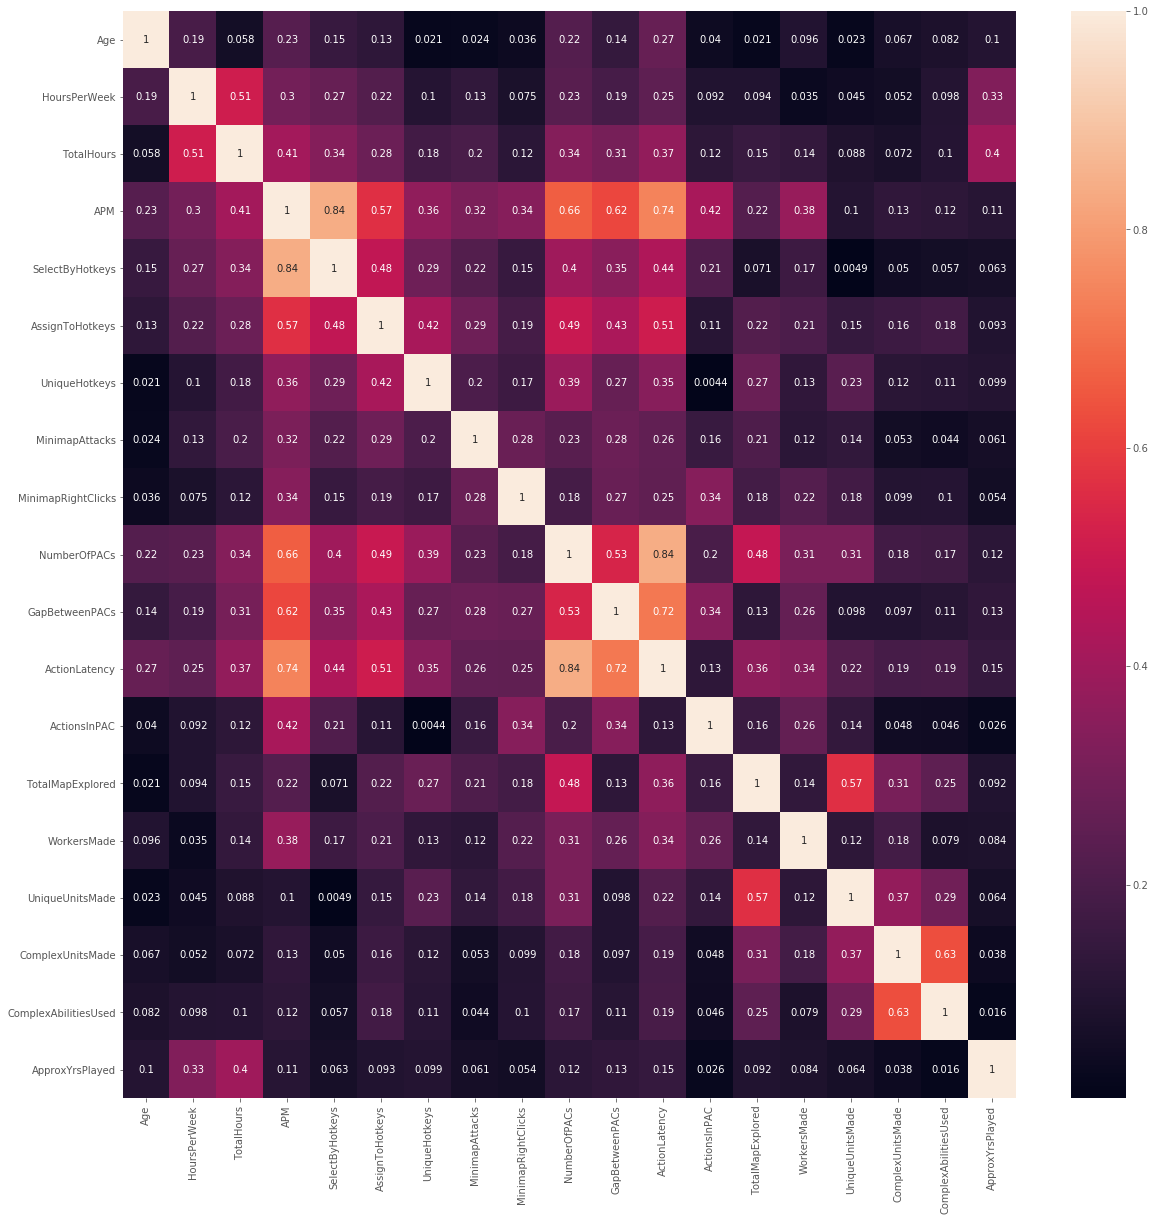

In [79]:
plt.figure(figsize = [20, 20])
sns.heatmap(fixed_X_train_scaled_sample.corr().abs(), annot = True)

In [80]:
fit_model(rf_clf, fixed_X_train_scaled_sample, fixed_X_test_scaled, fixed_y_train_sample, fixed_y_test, 
          param_grid_rf, feature_importances = 10, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 100}

Best Accuracy Score: 0.7671
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.662

Feature ranking:
1: Score 0.136, Feature Name: ActionLatency
2: Score 0.105, Feature Name: APM
3: Score 0.079, Feature Name: NumberOfPACs
4: Score 0.078, Feature Name: TotalHours
5: Score 0.07, Feature Name: SelectByHotkeys
6: Score 0.066, Feature Name: MinimapAttacks
7: Score 0.061, Feature Name: GapBetweenPACs
8: Score 0.056, Feature Name: AssignToHotkeys
9: Score 0.046, Feature Name: ApproxYrsPlayed
10: Score 0.038, Feature Name: UniqueHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [81]:
tokeep = ['ActionLatency', 'APM', 'TotalHours', 'SelectByHotkeys', 'NumberOfPACs', 
          'MinimapAttacks', 'AssignToHotkeys', 'GapBetweenPACs', 'ApproxYrsPlayed', 'WorkersMade']
final_data = fixed_data[tokeep]

In [82]:
final_y = fixed_data['Group']
final_X = fixed_data.drop('Group', axis = 1)

In [83]:
final_X_train, final_X_test, final_y_train, final_y_test = train_test_split(
    final_X, final_y, test_size = 0.30, random_state = 42)

In [84]:
sm = SMOTE()
final_X_train_sample, final_y_train_sample = sm.fit_resample(final_X_train, final_y_train)
final_X_train_sample = pd.DataFrame(final_X_train_sample, 
                              columns = final_X.columns)

In [85]:
scaler = StandardScaler()
final_X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(final_X_train_sample), 
                              columns = final_X.columns)
final_X_test_scaled = pd.DataFrame(scaler.transform(final_X_test), 
                              columns = final_X.columns, index = final_X_test.index)

In [86]:
fit_model(rf_clf, final_X_train_scaled_sample, final_X_test_scaled, final_y_train_sample, final_y_test, 
          param_grid_rf, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'n_estimators': 100}

Best Accuracy Score: 0.7644
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6791


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
best_estimator = GridSearchCV(rf_clf, param_grid_rf, cv = 3, scoring = 'accuracy')
best_estimator.fit(final_X_train_scaled_sample, final_y_train_sample)
y_pred = best_estimator.best_estimator_.predict(final_X_test_scaled)

Text(0.5, 1.0, 'Random Forest Best Estimator Actual vs Predicted Values')

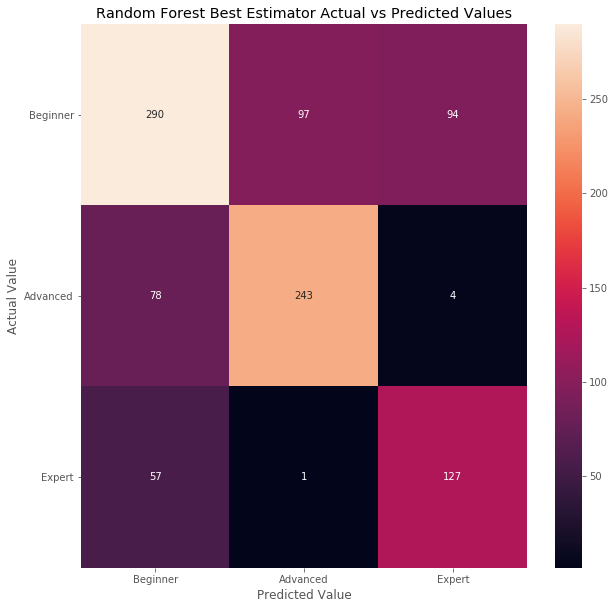

In [88]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(final_y_test, y_pred), annot = True, fmt = 'g', 
            xticklabels = ['Beginner', 'Advanced', 'Expert'], 
            yticklabels = ['Beginner', 'Advanced', 'Expert'])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.yticks(rotation = 0)
plt.title("Random Forest Best Estimator Actual vs Predicted Values")